Continued...

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit

from astropy.coordinates import SkyCoord

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *

from scipy.stats import norm

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))

# Most skewed PDFs and summary statistics

6dFGS
Median logdist: 0.007

SDSS
Median logdist: -0.02

LAMOST
Median logdist: -0.023

Median logdist: -0.006
Median logdist error: 0.103 | 23.7
Median logdist alpha: -0.717
6dFGS | [6118, 6200]
LAMOST | [1643, 1487]


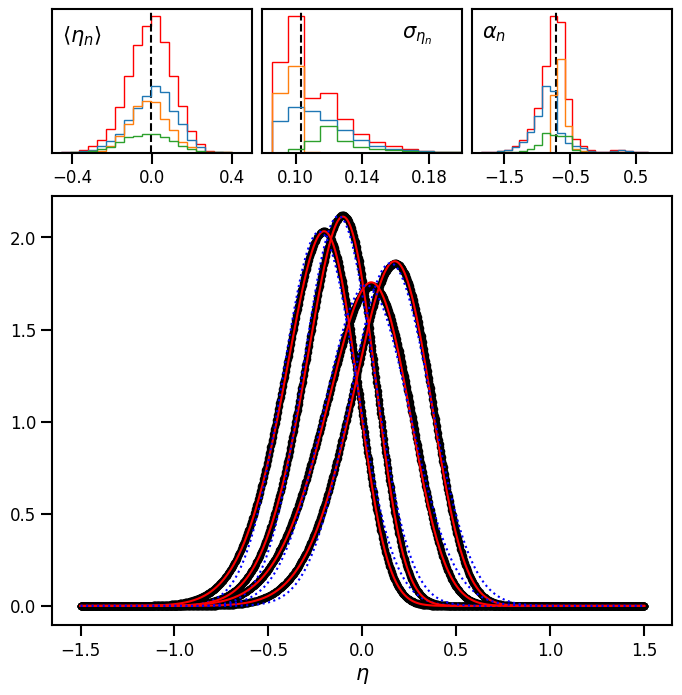

In [ ]:
mpl.rcParams['axes.linewidth'] = 1.5

def skew_normal(x, loc, scale, alpha):
    def std_normal(x):
        return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
    
    def cdf(x):
        return 0.5 * (1 + erf(x / np.sqrt(2)))
    
    return (2 / scale) * std_normal((x - loc) / scale) * cdf(alpha * (x - loc) / scale) * 0.988

fp_fit = "ALL_COMBINED"
method = "common_abc" # individual, combined, or common_abc
fp_fit_method = 0   # 0 (full f_n) or 1 (partial f_n)

# Candidate log-distance ratios
dmin, dmax, nd = -1.5, 1.5, 1001
dbins = np.linspace(dmin, dmax, nd, endpoint=True)

# Differentiate 3 survey colors
colors = ["C0", "C1", "C2"]

# Create a figure
a_ = 8
fig = plt.figure(figsize=(a_ , a_ ))
NBINS = 25

# Create a GridSpec with 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 3], wspace=0.05, hspace=0.15)

# First axis: edge-on FP (r_obs vs r_pred)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Axis 2, 3, 4: bivariate distributions (r vs i, r vs s, i vs s)
ax4 = fig.add_subplot(gs[1, :])


# Histograms of logdist parameters
df_combined = pd.DataFrame()
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    df_combined = pd.concat([df_combined, df], axis=0)

logdist_mean_bins = np.linspace(df_combined[f"logdist_mean_{method}"].min(), df_combined[f"logdist_mean_{method}"].max(), NBINS)
logdist_scale_bins = np.linspace(df_combined[f"logdist_scale_{method}"].min(), df_combined[f"logdist_scale_{method}"].max(), NBINS)
logdist_alpha_bins = np.linspace(df_combined[f"logdist_alpha_{method}"].min(), df_combined[f"logdist_alpha_{method}"].max(), NBINS)
ax1.hist(df_combined[f"logdist_{method}"], bins=logdist_mean_bins, histtype="step", color='r')
ax2.hist(df_combined[f"logdist_err_{method}"], bins=logdist_scale_bins, histtype="step", color='r')
ax3.hist(df_combined[f"logdist_alpha_{method}"], bins=logdist_alpha_bins, histtype="step", color='r')
ax1.axvline(df_combined[f"logdist_{method}"].quantile(0.5), c='k', ls="--")
ax2.axvline(df_combined[f"logdist_err_{method}"].quantile(0.5), c='k', ls="--")
ax3.axvline(df_combined[f"logdist_alpha_{method}"].quantile(0.5), c='k', ls="--")


for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    ax1.hist(df[f"logdist_{method}"], bins=logdist_mean_bins, histtype="step")
    ax2.hist(df[f"logdist_err_{method}"], bins=logdist_scale_bins, histtype="step")
    ax3.hist(df[f"logdist_alpha_{method}"], bins=logdist_alpha_bins, histtype="step")

    print(survey)
    median = np.round(df[f"logdist_{method}"].median(),3)
    print(f"Median logdist: {median}")
    print()
    df_combined = pd.concat([df_combined, df], axis=0)

# Typical logdist (combined sample)
logdist_median = np.round(df_combined[f"logdist_{method}"].median(), 3)
print(f"Median logdist: {logdist_median}")

# Typical error (combined sample)
logdist_err_median = np.round(df_combined[f"logdist_err_{method}"].median(), 3)
logdist_err_median_pct = np.round(df_combined[f"logdist_err_{method}"].median() * np.log(10) * 100, 1)
print(f"Median logdist error: {logdist_err_median} | {logdist_err_median_pct}")

# Typical alpha
logdist_alpha_median = np.round(df_combined[f"logdist_alpha_{method}"].median(), 3)
print(f"Median logdist alpha: {logdist_alpha_median}")

# Ax4: worst posteriod PDFs
for i, survey in enumerate(["6dFGS", "LAMOST"]):
    # Load posterior pdf
    posterior_pdfs = np.load(f"../artifacts/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}_posterior.npy")

    # Load worst PDFs
    df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey.lower()}.csv")
    df_worst = df[df[f"logdist_alpha_{method}"] < -1.4]
    df_worst = df_worst.sort_values(by=f'logdist_fit_rmse_{method}', ascending=False).head(2)
    worst_index = list(df_worst.index)
    print(f"{survey} | {worst_index}")
    logdist = df_worst[f"logdist_{method}"].tolist()
    logdist_err = df_worst[f"logdist_err_{method}"].tolist()
    loc_ = df_worst[f"logdist_loc_{method}"].tolist()
    scale_ = df_worst[f"logdist_scale_{method}"].tolist()
    alpha_ = df_worst[f"logdist_alpha_{method}"].tolist()

    for j, idx in enumerate(worst_index):
        # ax4.axvline(x=logdist[j])
        ax4.plot(dbins, skew_normal(dbins, loc=loc_[j], scale=scale_[j], alpha=alpha_[j]), c='r')
        ax4.plot(dbins, norm.pdf(dbins, loc=logdist[j], scale=logdist_err[j]), c='blue', ls=":")
        y = posterior_pdfs[idx]
        ax4.scatter(dbins, y, s=20, c='k')

# Remove y labels for histograms
labels_ = [r"$\langle \eta_n \rangle$", r"$\sigma_{\eta_n}$", r"$\alpha_n$"]
for i, ax in enumerate([ax1, ax2, ax3]):
    xloc = 0.05
    if i == 1:
        xloc = 0.7
    ax.set_yticks([])
    ax.tick_params(left=False)
    ax.text(xloc, 0.90, labels_[i], transform=ax.transAxes, fontsize=15, 
         verticalalignment='top', horizontalalignment='left')
ax4.set_xlabel(r"$\eta$", fontsize=15)

for i, ax in enumerate(fig.axes):
    ax.tick_params(axis='both', which='major', labelsize=12)

# Custom plot configs
ax1.set_xlim(-0.5, 0.5)
ax1.set_xticks([-0.4, 0, 0.4])

ax2.set_xlim(0.08, 0.2)
ax2.set_xticks([0.1, 0.14, 0.18])

ax3.set_xticks([-1.5, -0.5, 0.5,])

for ax in fig.axes:
    ax.tick_params(axis='both', which='major', length=8, width=1.5)

fig.savefig('../img/final_plot/fig_10_logdist_distributions.pdf', bbox_inches='tight', dpi=300)

# North vs South Consistency Check

## a. $abc$-fixed FP

Rejected comparison: 0
Rejected comparison: 0


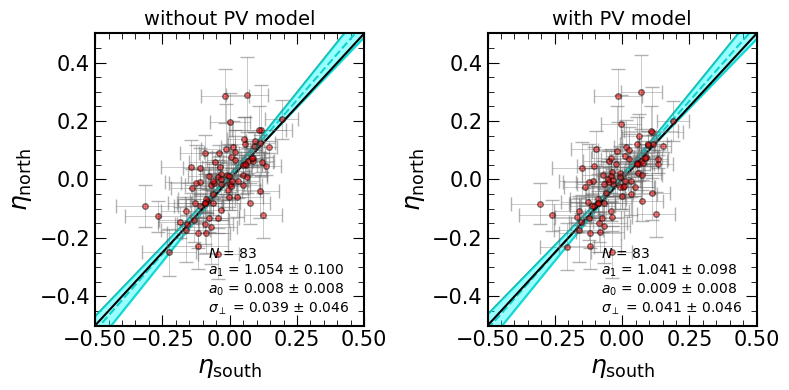

In [13]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
ax_titles = ['without PV model', 'with PV model']

req_cols = ['tmass', 'logdist_common_abc', 'logdist_obs_err_common_abc']

for i, datapath in enumerate(['../data/foundation/logdist/smin_setting_1/fp_fit_method_0/', '../experiments/experiment_009_logdist_pv_model/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')
        df_temp = df_temp[~df_temp['logdist_obs_err_common_abc'].isna()]
        df_north = pd.concat([df_north, df_temp])
    df_north = df_north[req_cols]

    # Read south (6dFGS) data
    df_south = pd.read_csv(datapath + '6dfgs.csv')
    df_south = df_south[~df_south['logdist_obs_err_common_abc'].isna()]
    df_south = df_south[req_cols]

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_common_abc_north"] - df[f"logdist_common_abc_south"]) / np.sqrt(df[f"logdist_obs_err_common_abc_north"]**2 + df[f"logdist_obs_err_common_abc_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_common_abc_south"].to_numpy()
    xerr = df[f"logdist_obs_err_common_abc_south"].to_numpy()
    y = df[f"logdist_common_abc_north"].to_numpy()
    yerr = df[f"logdist_obs_err_common_abc_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_common_abc_south"], df_rejects[f"logdist_common_abc_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err:.3f}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
fig.savefig('../img/final_plot/north_vs_south_common_abc.pdf', bbox_inches='tight', dpi=300)

## b. Individual FP

Rejected comparison: 0
Rejected comparison: 0


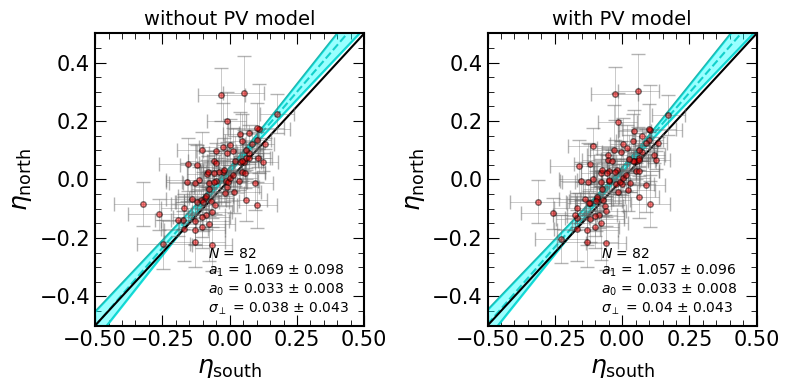

In [14]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
ax_titles = ['without PV model', 'with PV model']

req_cols = ['tmass', 'logdist_individual', 'logdist_obs_err_individual']

for i, datapath in enumerate(['../data/foundation/logdist/smin_setting_1/fp_fit_method_0/', '../experiments/experiment_009_logdist_pv_model/']):
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:
        df_temp = pd.read_csv(datapath + survey + '.csv')
        df_temp = df_temp[~df_temp['logdist_obs_err_individual'].isna()]
        df_north = pd.concat([df_north, df_temp])
    df_north = df_north[req_cols]

    # Read south (6dFGS) data
    df_south = pd.read_csv(datapath + '6dfgs.csv')
    df_south = df_south[~df_south['logdist_obs_err_individual'].isna()]
    df_south = df_south[req_cols]

    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_individual_north"] - df[f"logdist_individual_south"]) / np.sqrt(df[f"logdist_obs_err_individual_north"]**2 + df[f"logdist_obs_err_individual_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_individual_south"].to_numpy()
    xerr = df[f"logdist_obs_err_individual_south"].to_numpy()
    y = df[f"logdist_individual_north"].to_numpy()
    yerr = df[f"logdist_obs_err_individual_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_individual_south"], df_rejects[f"logdist_individual_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.42, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.tight_layout()
fig.savefig('../img/final_plot/north_vs_south_individual.pdf', bbox_inches='tight', dpi=300)

# Cross-survey consistency check

## a. $abc$-fixed FP

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 0
Rejected comparison in ('6dFGS', 'LAMOST'): 0


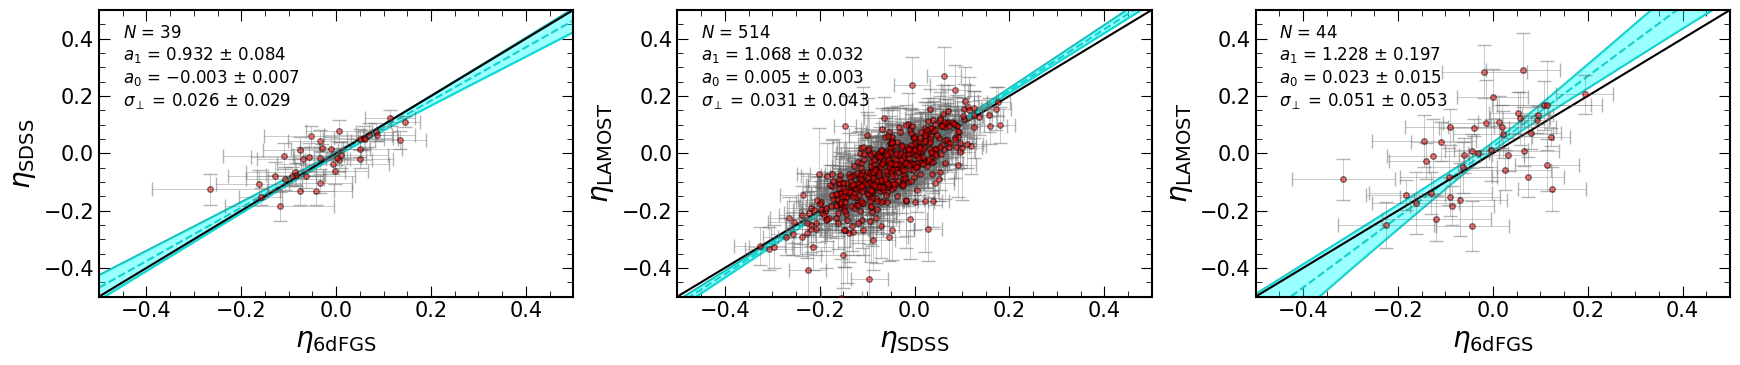

In [21]:
method = "common_abc"
SIGMA_CLIP = 3.0

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_common_abc_fp.pdf', bbox_inches='tight', dpi=300)

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 0
Rejected comparison in ('6dFGS', 'LAMOST'): 0


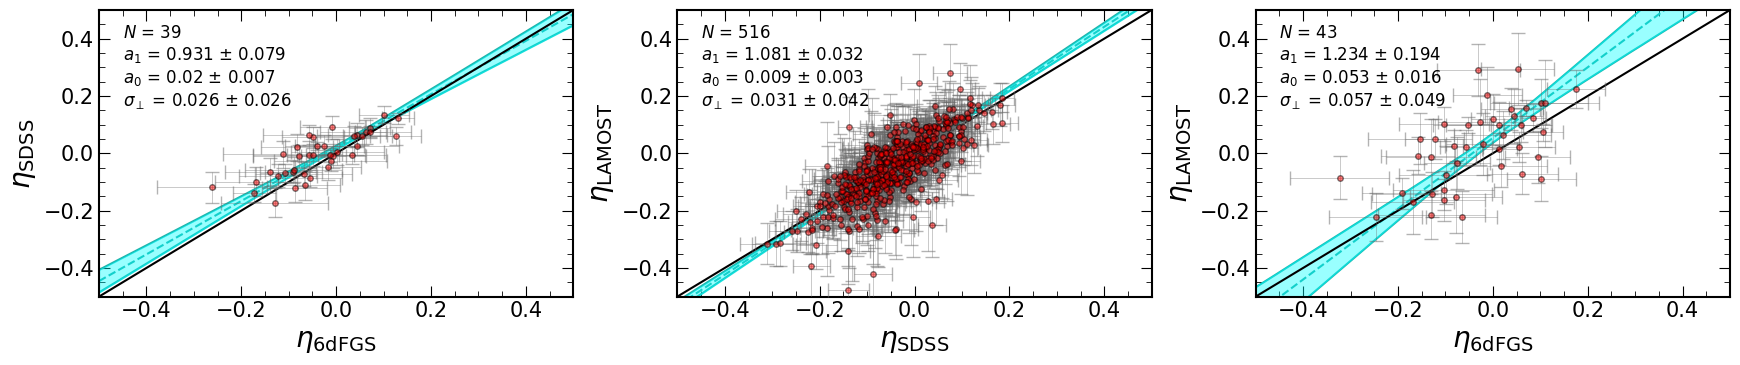

In [23]:
method = "individual"
SIGMA_CLIP = 3.0

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
fig.savefig('../img/final_plot/fig_11b_internal_consistency_checks_individual_fp.pdf', bbox_inches='tight', dpi=300)

Rejected comparison in ('6dFGS', 'SDSS'): 0
Rejected comparison in ('SDSS', 'LAMOST'): 0
Rejected comparison in ('6dFGS', 'LAMOST'): 0


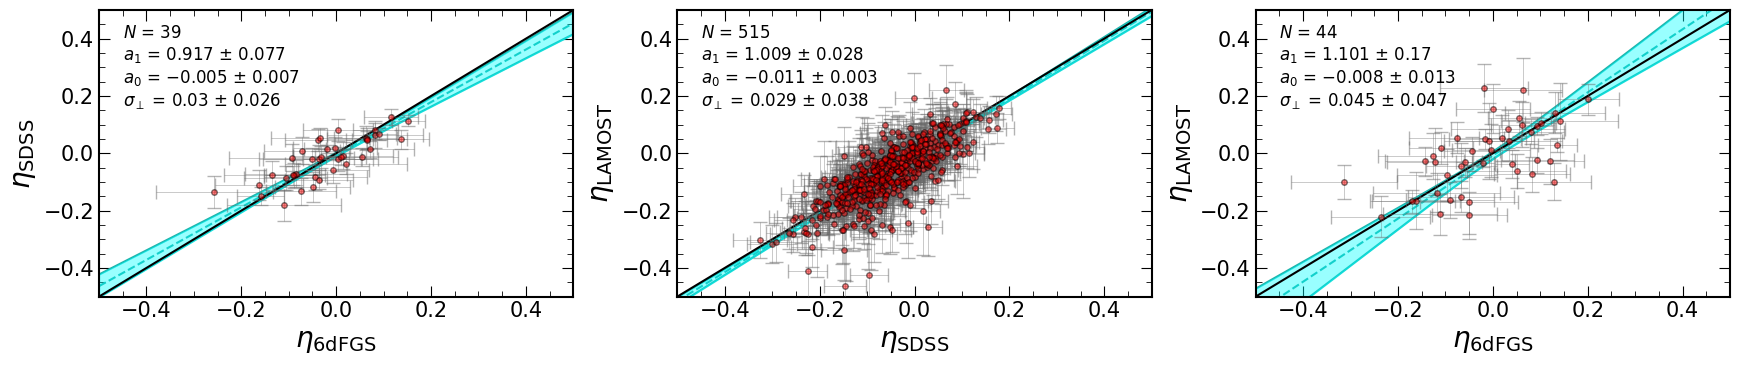

In [20]:
method = "combined"
SIGMA_CLIP = 3.5

def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    df1 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey1.lower()}.csv")
    df2 = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey2.lower()}.csv")
    df = df1.merge(df2, on='tmass', how='inner')
    df[f"chisq"] = np.absolute(df[f"logdist_{method}_x"] - df[f"logdist_{method}_y"]) / np.sqrt(df[f"logdist_obs_err_{method}_x"]**2 + df[f"logdist_obs_err_{method}_y"]**2)
    df_rejects = df[df[f"chisq"] > SIGMA_CLIP]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df[f"chisq"] <= SIGMA_CLIP]

    ndata = len(df)
    x = df[f"logdist_{method}_x"].to_numpy()
    xerr = df[f"logdist_obs_err_{method}_x"].to_numpy()
    y = df[f"logdist_{method}_y"].to_numpy()
    yerr = df[f"logdist_obs_err_{method}_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_{method}_x"], df_rejects[f"logdist_{method}_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    

fig.tight_layout()
# fig.savefig('../img/final_plot/fig_11a_internal_consistency_checks_combined_fp.pdf', bbox_inches='tight', dpi=300)

# Logdist Trends

Std of logdist:  0.1109120181109205
Std of absMag:  0.6893988514647105
Coefficient of correlation:  -0.8044111030593872
Predicted slope:  -0.12941544454504406
___ 22.188779163215976
___ 19.620357720273304
___ 13.69032395438384
___ 21.37245510539333
___ 18.945442183019786
___ 10.63014581273465
___ 18.439088914585774
___ 18.774978046267638
___ 10.18465843842649


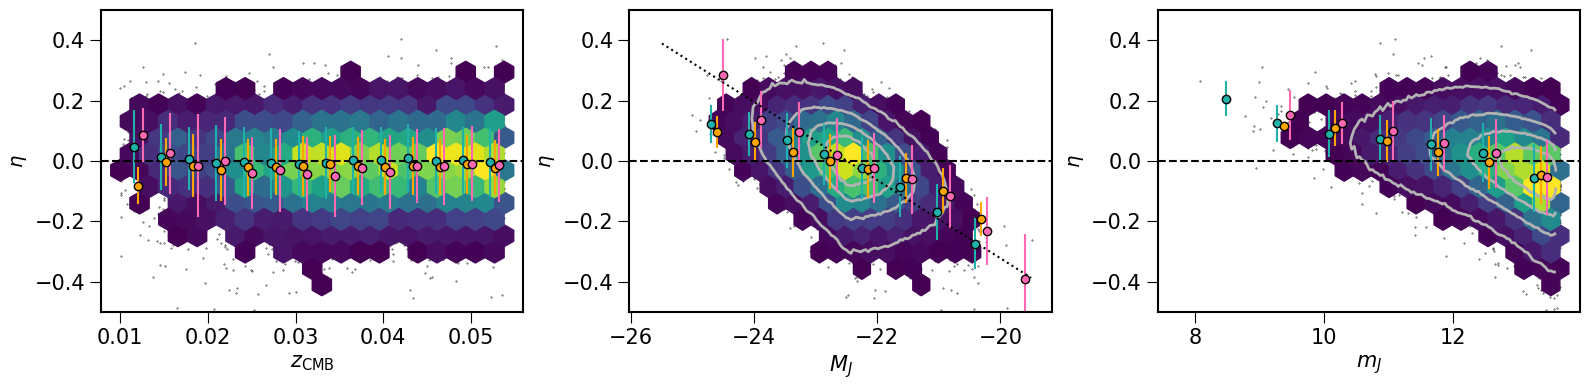

In [30]:
survey_list = ["6dFGS", "SDSS", "LAMOST"]
fig, axs = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))

# Load logdist-derived mocks
df_mock = pd.read_csv("../experiments/experiment_010_mock_logdist/mocks_all_combined.csv")
df_mock["mag_j"] -= df_mock["extinction_j"]

# Plot mock contour for absolute magnitude
mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]
density_contour(df_mock['absmag_j'].to_numpy(), df_mock['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=fig.axes[1], linewidths=2.0, linestyles="-")

# Plot mock contour for apparent magnitude
mock_cmap = plt.get_cmap("gray")
levels_plot_mock = [(0.25, (0.04, 0.04), mock_cmap(0.7)), (0.5, (0.04, 0.04), mock_cmap(0.7)), (0.75, (0.04, 0.04), mock_cmap(0.7)), (0.95, (0.04, 0.04), mock_cmap(0.7))]
density_contour(df_mock['mag_j'].to_numpy(), df_mock['logdist'].to_numpy(), bins_levels_tuple_list=levels_plot_mock, ax=fig.axes[2], linewidths=2.0, linestyles="-")

# Parameters for each plot
x_params = ["z_dist_est", "absMag_j", "mag_j"]
x_params_labels = [r"$z_\mathrm{CMB}$", r"$M_J$", r"$m_J$"]
n_data = [15, 10, 8]
offsets = [0.0005, 0.1, 0.1]
survey_colors = ["lightseagreen", "orange", "hotpink"]
survey_shapes = ["o", "o", "o"]

# Combine surveys
df_combined = pd.DataFrame()
for survey in survey_list:
    df_temp = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_temp["mag_j"] = df_temp["j_m_ext"] - df_temp["extinction_j"]
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Calculate J-band absolute magnitude
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
d_C = sp.interpolate.splev(df_combined["z_dist_est"].to_numpy(), dist_spline)
d_L = (1 + df_combined["zhelio"]) * d_C * 10**6
df_combined["absMag_j"] = (df_combined["j_m_ext"] - df_combined["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df_combined["kcor_j"]

sigma_eta = np.std(df_combined["logdist_common_abc"])
sigma_M = np.std(df_combined["absMag_j"])
print("Std of logdist: ", sigma_eta)
print("Std of absMag: ", sigma_M)
print("Coefficient of correlation: ", -5 * sigma_eta / sigma_M)
print("Predicted slope: ", -5 * sigma_eta**2 / sigma_M**2)

# Merge with John's GALFIT measurements to get sersic index
df_galfit = pd.read_csv("../data/raw/r_e_jrl/combined/jhk_r_e.csv")[["tmass", "galfit_ser_j"]]
df_combined = df_combined.merge(df_galfit, on="tmass", how="left")

# Separate the dataframe again
dfs = []
for survey in survey_list:
    dfs.append(df_combined[df_combined["survey"] == survey])


for i, ax in enumerate(fig.axes):
    # Parameter to plot
    x_param = x_params[i]

    ax.scatter(df_combined[x_param], df_combined['logdist_common_abc'], s=0.1, c='k')
    h = ax.hexbin(df_combined[x_param], df_combined['logdist_common_abc'], gridsize=(20, 10), mincnt=5, cmap="viridis")

    for j, survey in enumerate(survey_list):
        offset = j * offsets[i]

        df_ = dfs[j]
        
        x = df_[x_param].to_numpy()
        y = df_["logdist_common_abc"].to_numpy()
        yerr = df_["logdist_err_common_abc"].to_numpy()

        x_full = df_combined[x_param].to_numpy()
        x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data(x=x, y=y, yerr=yerr, xmin=x_full.min(), xmax=x_full.max(), n_bin=n_data[i])

        print("___", np.median(y_bin_err/y_bin_stderr))

        ax.errorbar(x_bin + offset, y_bin, yerr=y_bin_err, fmt=survey_shapes[j], mec='k', mfc=survey_colors[j], ecolor=survey_colors[j], alpha=1.0)
    
    ax.axhline(y=0, c='k', ls='--')

    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(x_params_labels[i], fontsize=15)
    ax.set_ylabel(r"$\eta$", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

# Predicted slope for middle panel
m = -5 * sigma_eta**2 / sigma_M**2
x0 = np.median(df_combined["absMag_j"])
x_trial = np.linspace(-25.5, -19.5, 50)
y_trial = m * (x_trial - x0)
ax = fig.axes[1]
ax.plot(x_trial, y_trial, c='k', ls=':')
 
fig.tight_layout()
fig.savefig('../img/final_plot/fig_12_logdist_trend.pdf', bbox_inches='tight', dpi=300)

# PV bias vs redshift

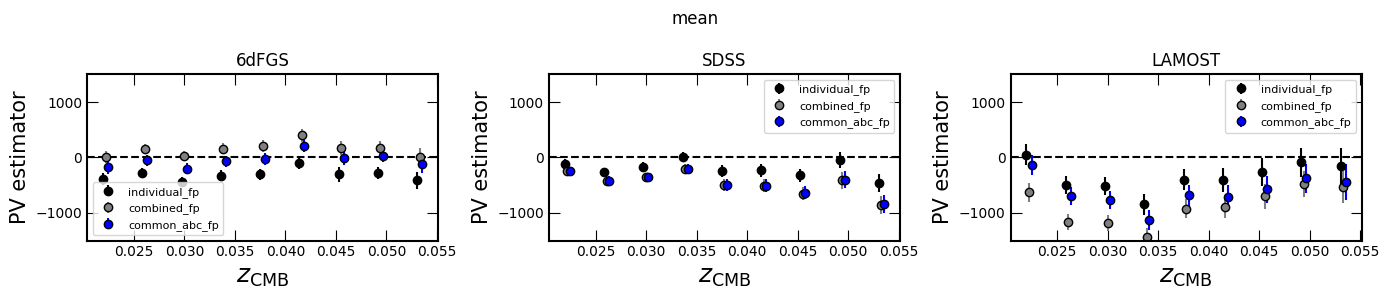

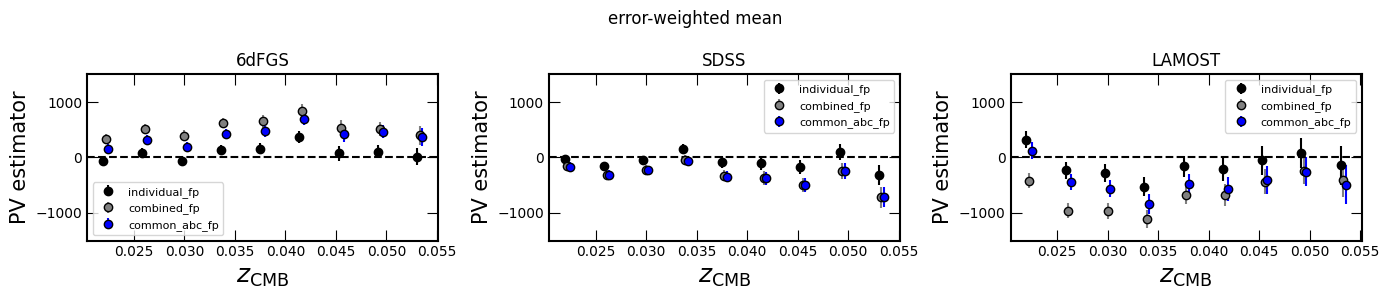

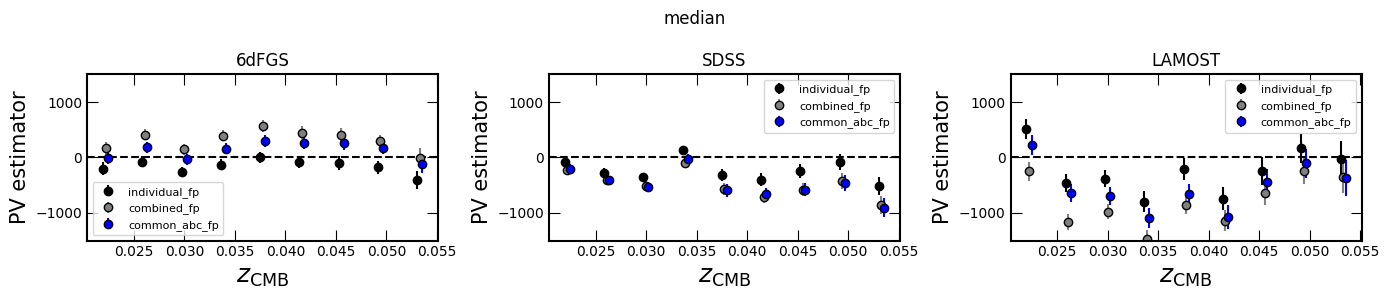

In [31]:
# Functions to average the data
avg_functions = [bin_data, bin_data_error_weighting, bin_data_median]
avg_func_labels = ["mean", "error-weighted mean", "median"]

for i, func in enumerate(avg_functions):
    fig, axs = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(avg_func_labels[i])

    for j, survey in enumerate(SURVEY_LIST):
        ax = fig.axes[j]

        # Load old data
        df = pd.read_csv(f"../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
        df["logdist_individual_fp"] = df[f"logdist_individual"]
        df["logdist_err_individual_fp"] = df[f"logdist_err_individual"]

        df["logdist_combined_fp"] = df["logdist_combined"]
        df["logdist_err_combined_fp"] = df["logdist_err_combined"]

        df["logdist_common_abc_fp"] = df["logdist_common_abc"]
        df["logdist_err_common_abc_fp"] = df["logdist_err_common_abc"]

        epsilon = 0.75
        z_col = "z_dist_est"

        colors = ["black", "grey", "blue", "red", "green"]

        for k, method in enumerate(["individual_fp", "combined_fp", "common_abc_fp"]):
            df["pv"] = LIGHTSPEED * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
            df["pv_err"] = LIGHTSPEED * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

            # Get error-weighted average in bins
            x = df[z_col].to_numpy()
            y = df[f"pv"].to_numpy()
            yerr = df[f"pv_err"].to_numpy()

            # Bin the data in redshift
            x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = func(x, y, yerr, 0.02, 0.055, 10)

            # Plot
            ax.errorbar(x_bin + k * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[k], ecolor=colors[k], alpha=1.0, label=method)

        ax.set_title(survey)
        ax.axhline(y=0, c='k', ls='--')
        ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
        ax.set_ylabel("PV estimator", fontsize=15)

        ax.set_ylim(-1500, 1500)
        ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
        ax.tick_params(axis='both', which='both', labelsize=10, direction="in")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

        if j == 0:
            ax.legend(loc="lower left", fontsize=8)
        else:
            ax.legend(loc="upper right", fontsize=8)

    fig.tight_layout()
    # fig.savefig(f"./pv_bias_{avg_func_labels[i]}.png", bbox_inches='tight', dpi=300)

# Logdist vs richness

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_17643/3096540901.py:78: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.errorbar(richness_bins_middle * (base ** i), logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o', mec=survey_colors[i], mfc=survey_colors[i], marker=survey_shapes[i], ecolor=survey_colors[i], alpha=ALPHA)
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_17643/3096540901.py:79: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.errorbar(richness_bins_middle * (base ** (i+1)), logdist_pred_binned_mean, yerr=logdist_pred_binned_stderr, fmt='o', marker=survey_shapes[i], mfc='none', mec=survey_colors[i], ecolor=survey_colors[i], alpha=ALPHA)
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_17643/3096540901.py:7

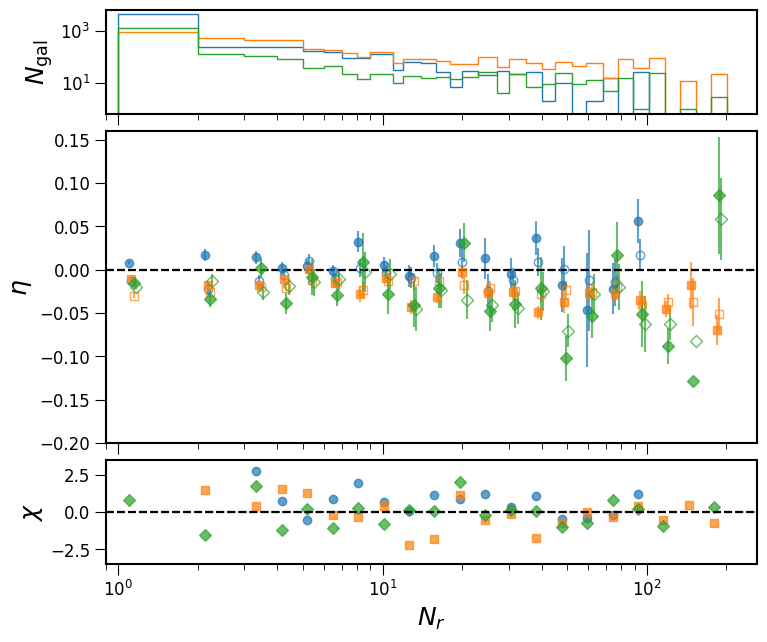

In [34]:
# Linear function
def linear_func(x, m, c):
    return m * x + c

survey_colors = ["C0", "C1", "C2"]
survey_shapes = ["o", "s", "D"]
ALPHA = 0.7
fp_method = "common_abc"

scale = 1.2
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(7 * scale, 6 * scale), height_ratios=[1, 3, 1], sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
for i, survey in enumerate(SURVEY_LIST):
    # Load log-distance ratio
    df = pd.read_csv(f'../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv')

    # Calculate J-band absolute magnitude
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    d_C = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    d_L = (1 + df["zhelio"]) * d_C * 10**6
    df["absMag_j"] = (df["j_m_ext"] - df["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df["kcor_j"]

    # Calculate absolute magnitude rolling mean
    x_param = "absMag_j"
    window_size = 0.1
    x_pts = np.linspace(df[x_param].min(), df[x_param].max(), 25)

    x = df["absMag_j"].to_numpy()
    y = df[f"logdist_{fp_method}"].to_numpy()
    yerr = df[f"logdist_err_{fp_method}"].to_numpy()

    x_bin, y_bin, y_bin_err, y_bin_stderr = bin_data_error_weighting(x, y, yerr, x.min(), x.max(), 15)

    # Fit linear relationship
    popt, pcov = curve_fit(linear_func, x_bin, y_bin, p0=[-0.1, -10])

    x_ = np.linspace(x.min(), x.max(), 100)
    y_ = linear_func(x_, popt[0], popt[1])

    # Richness bins
    richness_bins = np.logspace(-0.01, np.log10(200), 25)
    richness_bins_labels = range(1, len(richness_bins))

    # Median richness in each bin
    df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
    absmag_binned_median = df[['richness_bin', "absMag_j"]].groupby(by='richness_bin', observed=False).median().values.ravel()

    # Predicttion from linear relation
    logdist_pred = linear_func(absmag_binned_median, popt[0], popt[1])
    logdist_pred_err = 0.08

    # Predict log-distance ratio from the trend
    df['logdist_pred'] = linear_func(df['absMag_j'].to_numpy(), *popt)

    # Richness bins
    richness_bins = np.logspace(-0.01, np.log10(200), 25)
    richness_bins_labels = range(1, len(richness_bins))

    # Histogram of group richness
    histogram_bins = np.unique(np.ceil(np.logspace(0., np.log10(200), 40)))
    ax1.hist(df["Nr"], bins=histogram_bins, edgecolor=survey_colors[i], histtype='step')
    ax1.set_yscale("log")
    ax1.set_ylabel("$N_\mathrm{gal}$", fontsize=18)

    # Trend of logdist vs richness
    df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
    richness_bins_middle = 0.5 * (richness_bins[1:] + richness_bins[:-1])
    logdist_binned_mean = df[['richness_bin', f"logdist_{fp_method}"]].groupby(by='richness_bin', observed=False).median().values.ravel()
    logdist_binned_std = df[['richness_bin', f"logdist_{fp_method}"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()
    logdist_binned_stderr = df[['richness_bin', f"logdist_{fp_method}"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['richness_bin', f"logdist_{fp_method}"]].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())

    # Predicted logdist from logdist vs absolute magnitude relation
    err_absmag_relation = 0.08
    logdist_pred_binned_mean = df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).median().values.ravel()
    logdist_pred_binned_stderr = np.sqrt(df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()**2 + err_absmag_relation**2) / np.sqrt(df[['richness_bin', "logdist_pred"]].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())

    base = 1.02
    ax2.errorbar(richness_bins_middle * (base ** i), logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o', mec=survey_colors[i], mfc=survey_colors[i], marker=survey_shapes[i], ecolor=survey_colors[i], alpha=ALPHA)
    ax2.errorbar(richness_bins_middle * (base ** (i+1)), logdist_pred_binned_mean, yerr=logdist_pred_binned_stderr, fmt='o', marker=survey_shapes[i], mfc='none', mec=survey_colors[i], ecolor=survey_colors[i], alpha=ALPHA)

    ax2.axhline(y=0, c='k', ls='--')
    ax2.set_ylabel(r"$\eta$".replace("survey", survey), fontsize=18)
    ax2.set_ylim(-0.2, 0.16)

    # Calculate statistical significance
    chisq = (logdist_binned_mean - logdist_pred_binned_mean) / np.sqrt(logdist_binned_stderr**2 + logdist_pred_binned_stderr**2)
    ax3.scatter(richness_bins_middle, chisq, c=survey_colors[i], marker=survey_shapes[i], alpha=ALPHA)
    ax3.axhline(y=0, c='k', ls='--')

    ax3.set_ylabel(r"$\chi$", fontsize=18)
    ax3.set_xlabel(r"$N_r$", fontsize=18)
    ax3.set_xscale("log")
    ax3.set_xlim(left=0.9)
    ax3.set_ylim(-3.5, 3.5)

    for ax in fig.axes:
        ax.tick_params(axis='both', which='both', labelsize=12, direction="out")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

fig.savefig(f'../img/final_plot/logdist_richness.pdf', bbox_inches='tight', dpi=300)

# Comparison with CF4

Rejected comparison in common_abc: 0
Rejected comparison in common_abc: 1
Rejected comparison in common_abc: 0
Rejected comparison in individual: 0
Rejected comparison in individual: 1
Rejected comparison in individual: 0
Rejected comparison in combined: 0
Rejected comparison in combined: 1
Rejected comparison in combined: 0


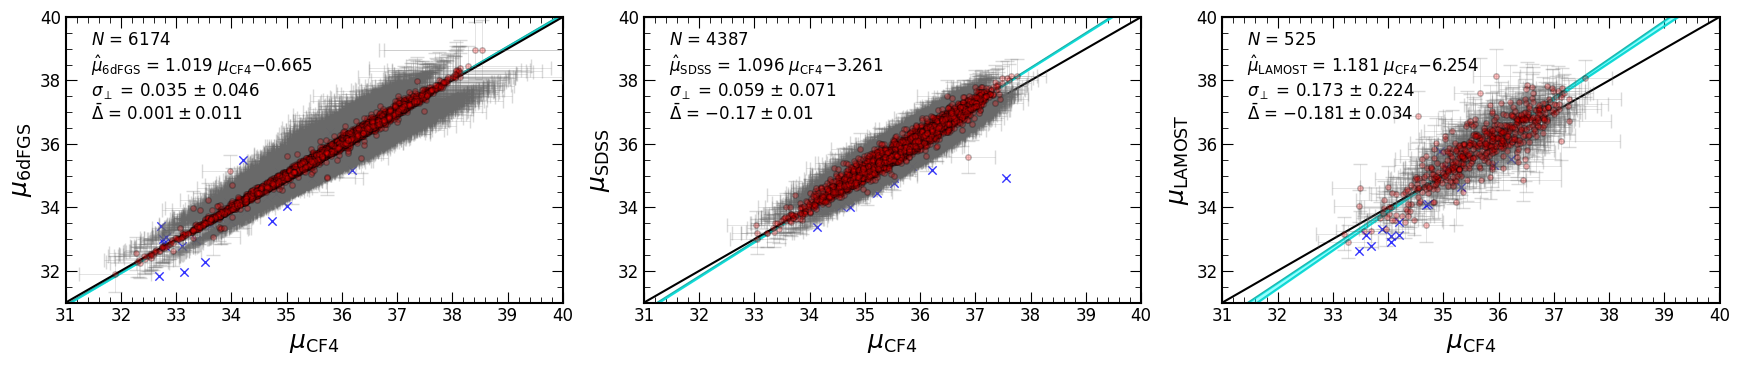

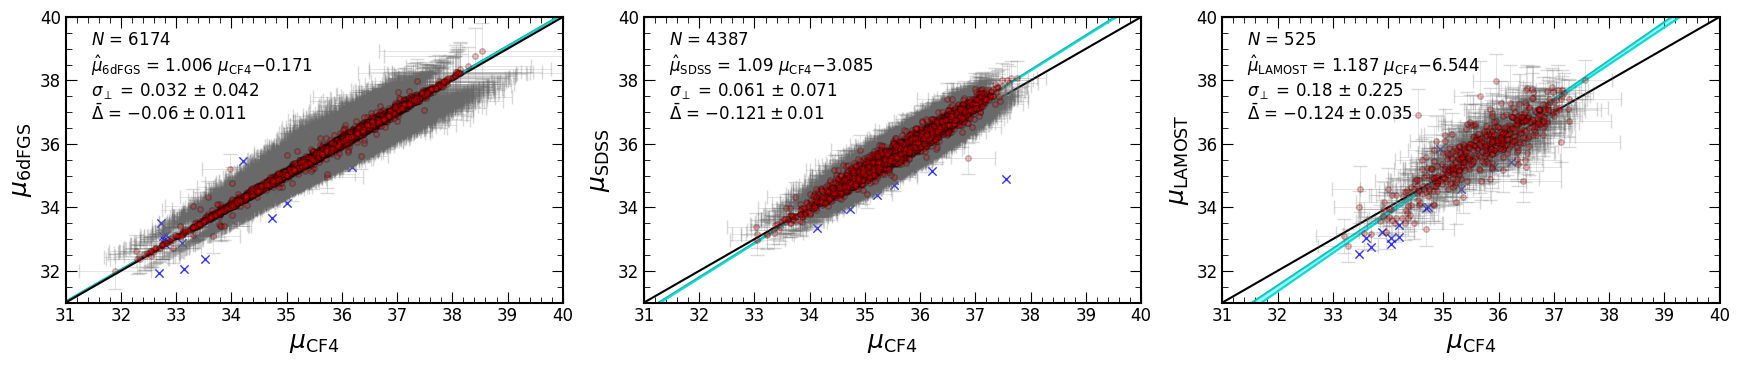

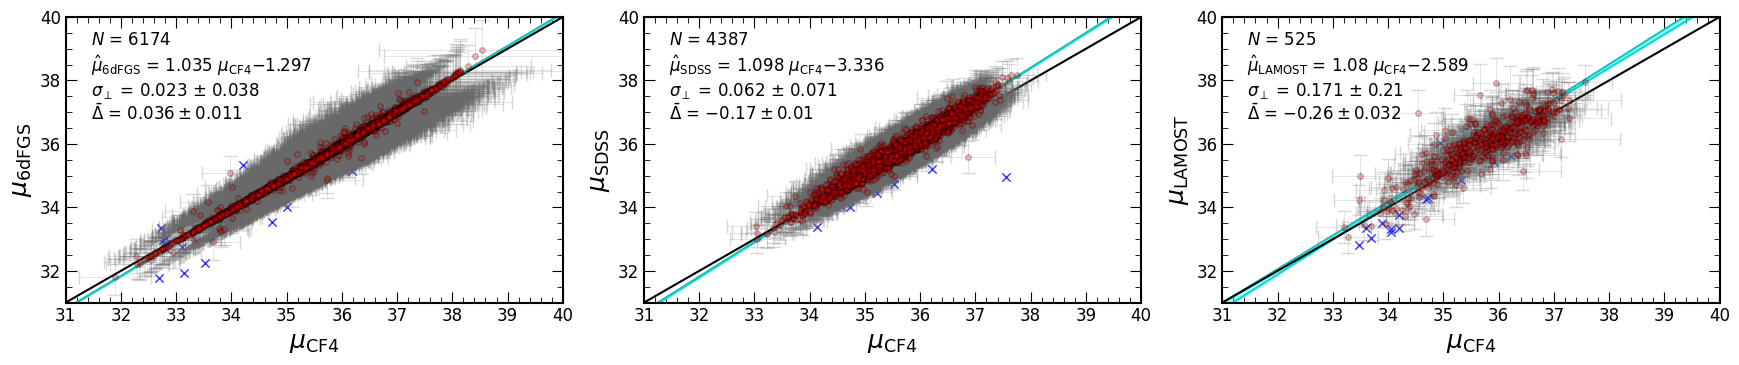

In [56]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

# Load CF4 individual distance data
df_cf4 = pd.read_csv("../data/external/cf4/raw/CF4_all_individual.txt")[["pgc", "DM", "eDM", 'DMfp', 'DMsnIa', 'DMtf', 'DMsbf',
           'DMsnII','DMtrgb', 'DMcep', 'DMmas',]]
df_cf4.rename({"DM": "DM_cf4", "eDM": "eDM_cf4"}, axis=1, inplace=True)

# PGC of galaxies other distance measurements
_ = df_cf4[(~df_cf4["DMsnIa"].isna()) | (~df_cf4["DMtf"].isna()) | (~df_cf4["DMsbf"].isna()) | (~df_cf4["DMsnII"].isna()) | (~df_cf4["DMtrgb"].isna()) | (~df_cf4["DMcep"].isna()) | (~df_cf4["DMmas"].isna())]
galaxy_ids = _["pgc"].values.tolist()


for method in ["common_abc", "individual", "combined"]:
    # Constants
    sigma_clip = 3.5
    figure_size = 5
    fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

    for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):

        # Load my DM measurements
        df_mine = pd.read_csv(f"../data/foundation/distance_modulus/{survey.lower()}.csv")

        # Custom
        if survey == "6dFGS":
            ylabel = r"$\mu_\mathrm{6dFGS}$"
            survey_text = r"$\hat{\mu}_\mathrm{6dFGS}$"
        elif survey == "SDSS":
            ylabel = r"$\mu_\mathrm{SDSS}$"
            survey_text = r"$\hat{\mu}_\mathrm{SDSS}$"
        elif survey == "LAMOST":
            ylabel = r"$\mu_\mathrm{LAMOST}$"
            survey_text = r"$\hat{\mu}_\mathrm{LAMOST}$"

        # Fetch PGC ID
        df_lookup = pd.read_csv(f"../data/external/pgc/{survey.lower()}.csv")
        df_mine = df_mine.merge(df_lookup, on="survey_id", how="left")

        # Merge my data and CF4
        df_full = df_mine.merge(df_cf4, on="pgc", how="left")

        # Reject outliers
        df = df_full.copy()
        df["chisq"] = np.absolute(df[f"DM_{method}"] - df["DM_cf4"]) / np.sqrt(df[f"eDM_{method}"]**2 + df["eDM_cf4"]**2)
        df_rejects = df[df["chisq"] > sigma_clip]
        print(f"Rejected comparison in {method}: {len(df_rejects)}")
        df = df[df["chisq"] <= sigma_clip]
        
        # Other methods
        df_rejects2 = df[df["pgc"].isin(galaxy_ids)]
        df_rejects = pd.concat([df_rejects, df_rejects2])
        df = df[~(df["pgc"].isin(galaxy_ids))]

        # Unpack data for offset calculation and ODR
        x = df[f"DM_cf4"].to_numpy()
        xerr = df[f"eDM_cf4"].to_numpy()
        y = df[f"DM_{method}"].to_numpy()
        yerr = df[f"eDM_{method}"].to_numpy()
        chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)
        ndata = len(x)

        delta = x - y
        delta_err = np.sqrt(xerr**2 + yerr**2)

        Delta = np.round(np.sum(delta / delta_err**2) / np.sum(1 / delta_err**2), 3) #np.round(np.average(delta), 3)#
        Epsilon = np.round(1 / np.sqrt(np.sum(1 / delta_err**2)), 3)

        # print(f"Offset: {np.round(Delta, 3)} ± {np.round(Epsilon, 3)}")

        # ODR stuff
        linear = Model(f)
        mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
        myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
        myoutput = myodr.run() 
        m_pred, b_pred = myoutput.beta
        # print(myoutput.beta)

        # Create MC sample
        n_trial = 10000
        m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

        # Plot boundaries
        left_ = 31
        right_ = 40
        x_trial = np.linspace(left_, right_, 1000)
        y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
        y_pred = m_pred * x_trial + b_pred
        y_lower = np.quantile(y_trial, q=0.16, axis=0)
        y_upper = np.quantile(y_trial, q=0.84, axis=0)

        # Plot stuff
        ax = fig.axes[i]

        # Actual data + error bars
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.25, zorder=3)

        # Prediction + confidence intervals
        # ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
        ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
        ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
        ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

        # Rejects
        ax.scatter(df_rejects["DM_cf4"], df_rejects[f"DM_{method}"], marker="x", c="blue", lw=1., alpha=0.8, zorder=2)

        ax.set_xlim(left_, right_)
        ax.set_ylim(left_, right_)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.set_xlabel(r"$\mu_\mathrm{CF4}$", fontsize=18)

        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
        ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)

        # 1-to-1 line
        ax.plot([left_, right_], [left_, right_], c='k')

        # Add text
        N_value = len(df)
        m_value = np.round(myoutput.beta[0], 3)
        m_err = np.round(myoutput.sd_beta[0], 3)
        b_value = np.round(myoutput.beta[1], 3)
        b_err = np.round(myoutput.sd_beta[1], 3)
        sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
        sigma_value = np.round(np.median(sigma_ortho), 3)
        sigma_err = np.round(np.std(sigma_ortho), 3)
        delta_35 = np.round(35 - m_value * 35 - b_value, 3)

        N_text = rf"$N$ = {N_value}"
        y_text = survey_text + f" = ${m_value}$ " + r"$\mu_\mathrm{CF4}$" + rf"${b_value}$"
        delta_text = r"$\bar{\Delta}$" + rf" = ${Delta} \pm {Epsilon}$"
        sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
        text_ = N_text + "\n" + y_text + "\n" + sigma_text + "\n" + delta_text
        ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
            verticalalignment='top', horizontalalignment='left')
        
    fig.tight_layout()
    fig.savefig(f"../img/final_plot/cf4_comparison_{method}.pdf", bbox_inches='tight', dpi=300)

# 6dFGS vs SDSS (original)

m:  1.1100152010576922
b:  -3.8863715238720262


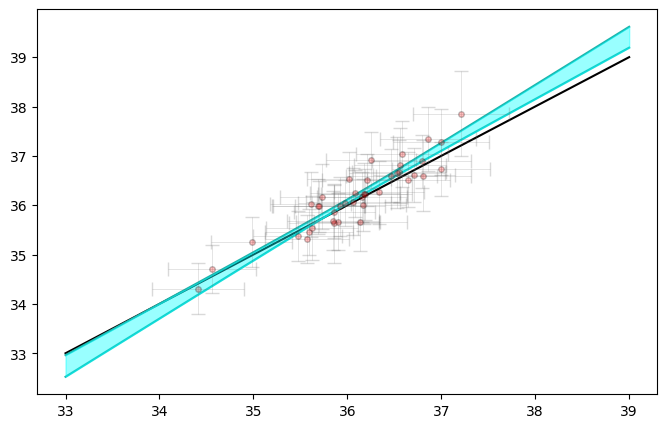

In [73]:
# df_6df = pd.read_csv("../data/external/cf4/raw/cf4_6dfgs_subsample.txt")[["pgc", "DM75", "eDM"]].rename(
#     {"DM75": "DM_6dfgs", "eDM": "eDM_6dfgs"}, axis=1
# )

# df_sdss = pd.read_csv("../data/external/cf4/raw/cf4_sdss_subsample.txt")[["pgc", "DMc75", "eDM"]].rename(
#     {"DMc75": "DM_sdss", "eDM": "eDM_sdss"}, axis=1
# )

# df = df_6df.merge(df_sdss, on="pgc", how="inner")

df = pd.read_csv("../data/external/cf4/raw/cf4_fp_distances.txt")[["DM_6dfgs", "eDM_6dfgs", "DM_fpsdss", "eDM_fpsdss"]]
df = df[(~df["DM_fpsdss"].isna()) & (~df["DM_6dfgs"].isna()) ]

# First ODR plot
ndata = len(df)
x = df[f"DM_fpsdss"].to_numpy()
xerr = df[f"eDM_fpsdss"].to_numpy()
y = df[f"DM_6dfgs"].to_numpy()
yerr = df[f"eDM_6dfgs"].to_numpy()
chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run() 
m_pred, b_pred = myoutput.beta

print("m: ", m_pred)
print("b: ", b_pred)

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

# Plot boundaries
left_ = 33
right_ = 39
x_trial = np.linspace(left_, right_, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

# Plot stuff
fig, ax = plt.subplots(figsize=(8, 5))

# Actual data + error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.25, zorder=3)

# Prediction + confidence intervals
ax.plot([left_, right_], [left_, right_], c='k')
ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)